In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## データの読み込みと前処理

In [3]:
data_path = '../data/Telecom_customer churn.csv'
df = pd.read_csv(data_path)
df_original = df.copy()
print(df.shape)
df.head()

(100000, 100)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [4]:
dtypes = [str(t) for t in df.dtypes.values]
info_df = pd.DataFrame({'column': df.count().index, 'count': df.count().values, 'dtype': dtypes})

remove_columns_df = info_df[info_df['count'] < 98000]
columns = list(df.columns)
for rmcol in remove_columns_df['column']:
    columns.remove(rmcol)
columns.remove('Customer_ID')

In [5]:
categorical_columns = []
for col in columns:
    if df[col].dtype == 'object':
        categorical_columns.append(col)

for col in categorical_columns:
    categ_set = set(df[col])
    if len(categ_set) >= 10:
        categorical_columns.remove(col)
        columns.remove(col)
    else:
        print(col + ': ' + str(categ_set))
df[categorical_columns].info()
print(len(columns))

new_cell: {'U', 'Y', 'N'}
refurb_new: {nan, 'R', 'N'}
marital: {nan, 'S', 'A', 'M', 'U', 'B'}
kid3_5: {nan, 'U', 'Y'}
kid6_10: {nan, 'U', 'Y'}
kid11_15: {nan, 'U', 'Y'}
kid16_17: {nan, 'U', 'Y'}
creditcd: {nan, 'Y', 'N'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   new_cell    100000 non-null  object
 1   asl_flag    100000 non-null  object
 2   dualband    99999 non-null   object
 3   refurb_new  99999 non-null   object
 4   marital     98268 non-null   object
 5   kid0_2      98268 non-null   object
 6   kid3_5      98268 non-null   object
 7   kid6_10     98268 non-null   object
 8   kid11_15    98268 non-null   object
 9   kid16_17    98268 non-null   object
 10  creditcd    98268 non-null   object
dtypes: object(11)
memory usage: 8.4+ MB
82


In [6]:
df = df[columns]
df['new_cell'].replace(['Y', 'N', 'U'], [0, 1, 2], inplace=True)
df['asl_flag'].replace(['Y', 'N'], [0, 1], inplace=True)
df['dualband'].replace(['T', 'N', 'Y', 'U'], [0, 1, 2, 3], inplace=True)
df['refurb_new'].replace(['R', 'N'], [0, 1], inplace=True)
df['marital'].replace(['M', 'B', 'A', 'S', 'U'], [0, 1, 2, 3, 4], inplace=True)
df['kid0_2'].replace(['Y', 'U'], [0, 1], inplace=True)
df['kid3_5'].replace(['Y', 'U'], [0, 1], inplace=True)
df['kid6_10'].replace(['Y', 'U'], [0, 1], inplace=True)
df['kid11_15'].replace(['Y', 'U'], [0, 1], inplace=True)
df['kid16_17'].replace(['Y', 'U'], [0, 1], inplace=True)
df['creditcd'].replace(['Y', 'N'], [0, 1], inplace=True)

## 31-60日間に解約するかの分類モデル
#### LightGBM with Optuna

In [7]:
from sklearn.model_selection import train_test_split


X, y = df.drop('churn', axis=1), df[['churn']]
X_train, X_rm, y_train, y_rm = \
    train_test_split(X, y, train_size=0.8, random_state=0)
X_valid, X_test, y_valid, y_test = \
    train_test_split(X_rm, y_rm, test_size=0.1, random_state=0)


In [8]:
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgbo

lgb_train = lgb.Dataset(
    X_train.astype(float), y_train,
    categorical_feature=categorical_columns
)
lgb_eval = lgb.Dataset(
    X_valid.astype(float), y_valid,
    categorical_feature=categorical_columns,
    reference=lgb_train
)

opt_params={
    'objective': 'binary',
    'metric': 'auc'
}

In [9]:
from IPython.display import clear_output

lgb_results = {}
model = lgbo.train(
    opt_params, lgb_train,
    valid_names=['train', 'valid'],
    valid_sets=[lgb_train, lgb_eval],
    categorical_feature=categorical_columns,
    num_boost_round=100,
    early_stopping_rounds=30,
    evals_result=lgb_results,
    show_progress_bar=False,
    verbose_eval=-1
)
best_params = model.params
clear_output()


In [10]:
print('Best Params:', best_params)

Best Params: {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 4.01168661128211, 'lambda_l2': 2.288514690817015e-05, 'num_leaves': 51, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100, 'num_iterations': 100, 'early_stopping_round': 30, 'categorical_column': [51, 52, 65, 66, 72, 74, 75, 76, 77, 78, 79]}


In [11]:
importance_df = \
    pd.DataFrame({'colname': df[columns].drop(['churn'], axis=1).columns})
importance_df['importance'] = \
    model.feature_importance(importance_type='gain')
importance_df[importance_df['importance'] > 1500].sort_values(
    by='importance', ascending=False
)

,colname,importance
80,eqpdays,12074.699445
48,months,9072.228419
1,mou_Mean,5893.469615
9,change_mou,5756.713864
2,totmrc_Mean,4306.235250
67,hnd_price,3259.500855
10,change_rev,3228.255689
61,avgqty,2332.301387
60,avgmou,1844.426347
59,avgrev,1824.954337


In [12]:
from sklearn.metrics import auc, roc_curve

print('AUC')
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
fpr, tpr, _ = roc_curve(y_train['churn'], y_pred)
print('train:\t{}'.format(auc(fpr, tpr)))

y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
fpr, tpr, _ = roc_curve(y_valid['churn'], y_pred)
print('valid:\t{}'.format(auc(fpr, tpr)))

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
fpr, tpr, _ = roc_curve(y_test['churn'], y_pred)
print('test:\t{}'.format(auc(fpr, tpr)))

AUC
train:	0.7668832112302376
valid:	0.6983442832211626
test:	0.6778302136804704


古い機種を交換した場合の解約率

解約割合
交換する場合:	 0.481
交換しない場合:	 0.407


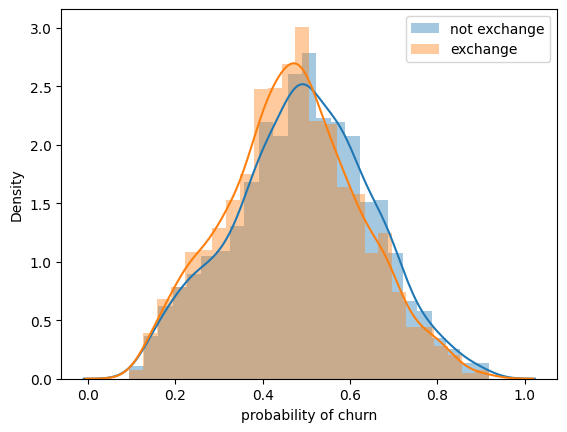

In [13]:
X_test_exchange = X_test.copy()
X_test_exchange['eqpdays'] = np.array([d if d < 548 else 0 for d in X_test_exchange['eqpdays']])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_exchange = model.predict(X_test_exchange, num_iteration=model.best_iteration)

y_churn = np.array([1 if p > 0.5 else 0 for p in y_pred])
y_churn_exchange = np.array([1 if p > 0.5 else 0 for p in y_pred_exchange])
print('解約割合')
print('交換する場合:\t', len(y_churn[y_churn == 1])/len(y_churn))
print('交換しない場合:\t', len(y_churn_exchange[y_churn_exchange == 1])/len(y_churn_exchange))

sns.distplot(y_pred, label='not exchange')
sns.distplot(y_pred_exchange, label='exchange')
plt.xlabel('probability of churn')
plt.legend()
plt.show()

## 契約月数の回帰予測モデル

In [14]:
X_train_reg, y_train_reg = \
    X_train.drop('months', axis=1).copy(), X_train['months'].copy()
X_valid_reg, y_valid_reg = \
    X_valid.drop('months', axis=1).copy(), X_valid['months'].copy()
X_test_reg, y_test_reg = \
    X_test.drop('months', axis=1).copy(), X_test['months'].copy()

X_train_reg['churn'] = y_train.copy()
X_valid_reg['churn'] = y_valid.copy()
X_test_reg['churn'] = y_test.copy()

In [15]:
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgbo

lgb_train = lgb.Dataset(
    X_train_reg.astype(float), y_train_reg,
    categorical_feature=categorical_columns
)
lgb_eval = lgb.Dataset(
    X_valid_reg.astype(float), y_valid_reg,
    categorical_feature=categorical_columns,
    reference=lgb_train
)

opt_params={
    'objective': 'regression',
    'metric': 'rmse'
}

In [16]:
from IPython.display import clear_output

lgb_results = {}
month_regmodel = lgbo.train(
    opt_params, lgb_train,
    valid_names=['train', 'valid'],
    valid_sets=[lgb_train, lgb_eval],
    categorical_feature=categorical_columns,
    num_boost_round=100,
    early_stopping_rounds=30,
    evals_result=lgb_results,
    show_progress_bar=False,
    verbose_eval=-1
)
clear_output()

In [17]:
best_params = month_regmodel.params
print('Best Params:', best_params)

Best Params: {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 5.93650406272406e-06, 'lambda_l2': 1.3378373344175371e-08, 'num_leaves': 155, 'feature_fraction': 0.948, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 100, 'early_stopping_round': 30, 'categorical_column': [50, 51, 64, 65, 71, 73, 74, 75, 76, 77, 78]}


In [18]:
from sklearn.metrics import mean_squared_error

y_pred = month_regmodel.predict(
    X_train_reg, num_iteration=month_regmodel.best_iteration
)
rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred))
print('train:\t{}'.format(rmse))

y_pred = month_regmodel.predict(
    X_valid_reg, num_iteration=month_regmodel.best_iteration
)
rmse = np.sqrt(mean_squared_error(y_valid_reg, y_pred))
print('valid:\t{}'.format(rmse))

y_pred = month_regmodel.predict(
    X_test_reg, num_iteration=month_regmodel.best_iteration
)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
print('test:\t{}'.format(rmse))

train:	1.3531989671795563
valid:	2.282338763201339
test:	1.9853962013421338


### モデルにより提案された契約月数を採用

In [19]:
X_test_recom = X_test_reg.copy()

# churnを0にして，解約されない月数を予測
X_test_recom['churn'] = [0] * len(X_test_reg)
recom_months = month_regmodel.predict(
    X_test_recom, num_iteration=month_regmodel.best_iteration
)
print(np.round(recom_months))

[26. 11. 15. ... 21. 14. 22.]


テストデータの月数を書き換えて，分類モデルで解約を予測

In [20]:
X_test_recom['months'] = np.round(recom_months)
X_test_recom = X_test_recom.drop('churn', axis=1)
y_pred = model.predict(
    X_test, num_iteration=model.best_iteration
)
y_pred_recom = model.predict(
    X_test_recom, num_iteration=model.best_iteration
)

In [21]:
print(y_pred.mean())
print(y_pred_recom.mean())

0.4905535465707222
0.3781165669133056


解約確率が下がった顧客の割合

In [22]:
print(((y_pred_recom - y_pred) < 0).sum() / len(y_pred))

0.7605


### 解約確率の分布
0.6以上の顧客を少なくすることができている

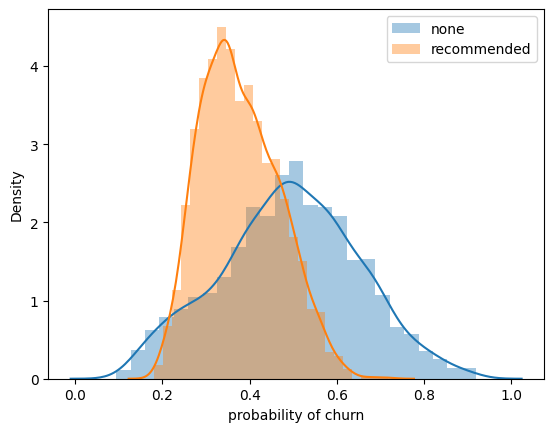

In [23]:
sns.distplot(y_pred, label='none')
sns.distplot(y_pred_recom, label='recommended')
plt.xlabel('probability of churn')
plt.legend()
plt.show()